In [21]:
import utils
import qiskit
import qiskit_aer
import numpy as np
from math import log
import qiskit.visualization
import matplotlib.pyplot as plt

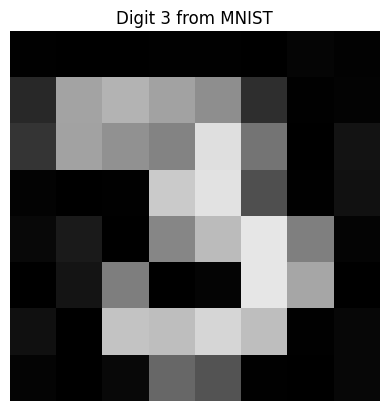

In [22]:
image = utils.plot_image('../images/three_8by8.jpg', 'Digit 3 from MNIST')

In [23]:
def equal_superposition(circ: qiskit.QuantumCircuit, start: int, end: int):
    for idx in range(start, end): 
        circ.h(idx)
        
def iterate(circ: qiskit.QuantumCircuit, padding: int, current_state: str, next_state: str):
    n = len(current_state)
    
    # Indices we must apply an X gate to go from current_state to next_state 
    #   - We reverse the state strings because we set the coordinates qubits in the circuit
    #       in descending order.
    x_targets = np.array([idx + padding for idx in range(n) 
                          if current_state[::-1][idx] != next_state[::-1][idx]])

    # Example
    # 1110 -> 1111
    #   if we don't reverse the strings we get:
    #   x_targets = [3]
    #   thus we will apply the X gate on the fourth qubit.
    #   but this is not what we want, we should apply it to the first qubit.
    #   think little endian vs big endian
    
    if x_targets.size > 0:
        circ.x(x_targets)

def pixel_encoding(circ: qiskit.QuantumCircuit, control: list, intensity: str):
    for idx, val in enumerate(intensity[::-1]):
        if int(val):
            circ.mcx(control_qubits=control,
                     target_qubit=idx)
            

In [24]:
w_bits = int(np.ceil(log(image.shape[1],2)))
h_bits = int(np.ceil(log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1
print(w_bits, h_bits)

3 3


In [25]:
im_list = image.flatten()
thetas = np.interp(im_list, (0, 255), (0, np.pi/2))
phis = np.interp(range(len(im_list)), (0, len(im_list)), (0, np.pi/2))

In [26]:
num_ind_bits = int(np.ceil(log(len(im_list),2)))
sorted_position_reg = qiskit.QuantumRegister(num_ind_bits, 'sorted_position') # Sorted coordinate (by intensity)
color_reg = qiskit.QuantumRegister(1,'color')  # Color
spatial_position_reg = qiskit.QuantumRegister(1, 'spatial_position') 
cr = qiskit.ClassicalRegister(num_ind_bits + 1 + 1, "bits")

In [27]:
controls = list(sorted_position_reg)

In [ ]:
qsmc_qsnc_circ = qiskit.QuantumCircuit(color_reg, spatial_position_reg, sorted_position_reg, cr)

In [29]:
def construct_qsmc_qsnc(circ: qiskit.QuantumCircuit, thetas, phis):
    num_qubits = circ.num_qubits
    equal_superposition(circ, 2, num_qubits)
    
    for i, (phi, theta) in enumerate(zip(phis, thetas)):
        qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
        
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                circ.x(sorted_position_reg[k])
                
        circ.barrier()
        
        for coord_or_intns in (0,1):
            if not coord_or_intns: # if intensity -> value == 0
                circ.mcry(theta=2*theta,
                            q_controls=controls,
                            q_target=color_reg[0]) # mcry application to color target
            else: # if coordinate -> value == 1
                circ.mcry(theta=2*phi,
                            q_controls=controls,
                            q_target=spatial_position_reg[0]) # mcry application to coordinate target
        
        circ.barrier()
        
        if  i!=len(thetas) - 1:
            for k, qub_ind in enumerate(qubit_index_bin):
                if int(qub_ind):
                    circ.x(sorted_position_reg[k])
                    
        circ.barrier()
        
    circ.measure(list(reversed(range(circ.num_qubits))), list(range(cr.size)))

In [30]:
construct_qsmc_qsnc(qsmc_qsnc_circ, thetas, phis)
qsmc_qsnc_circ.draw('mpl')

/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [31]:
simulator = qiskit_aer.AerSimulator()
circuit = qiskit.transpile(qsmc_qsnc_circ, simulator)
shots = 10000
result = simulator.run(circuit, shots=shots).result()

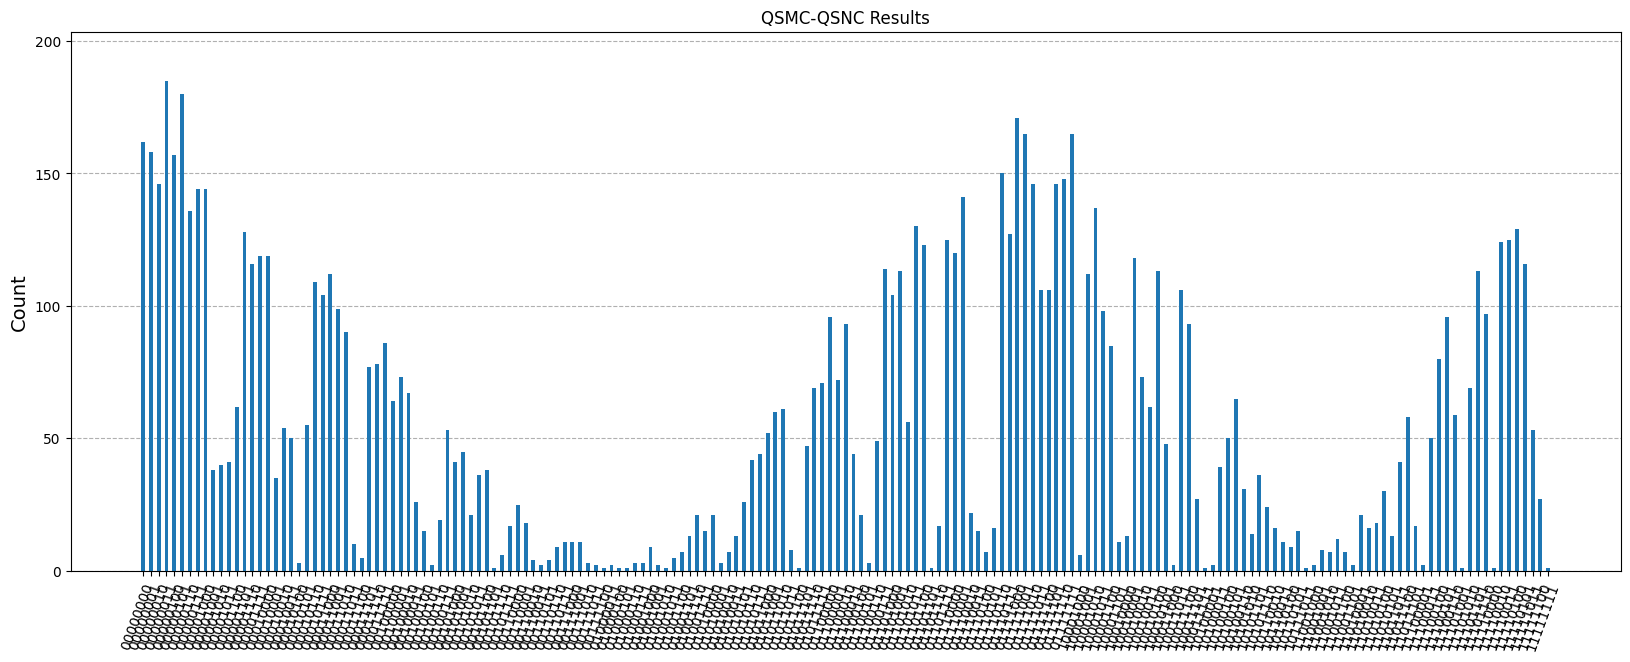

In [32]:
counts = result.get_counts(circuit)
qiskit.visualization.plot_histogram(counts, figsize=(20, 7), title="QSMC-QSNC Results", bar_labels=False)

In [33]:
ind_list = sorted(range(len(im_list)), key=lambda k:im_list[k]) # ordered by 0 > 255
max_index = max(ind_list)
print(ind_list)

[1, 2, 5, 22, 25, 34, 40, 43, 47, 49, 57, 62, 0, 3, 4, 14, 26, 30, 54, 61, 7, 15, 24, 39, 44, 56, 6, 55, 63, 32, 58, 48, 31, 23, 41, 33, 8, 13, 16, 29, 60, 59, 21, 42, 38, 19, 35, 12, 18, 11, 17, 9, 46, 10, 36, 51, 53, 50, 27, 52, 20, 28, 37, 45]


In [34]:
classical_colors = []
classical_coords = []
for i in range(0, max_index+1): # image pixels loop
    color_list = []
    coord_list = []
    for item in counts.items(): # counts items loop
        key = item[0] # quantum state
        amount = item[1] # counts value
        bin_coord = key[2:]
        int_coord = int(bin_coord, 2) # index value
        if int_coord == i: # if index == pixel position
                color_list.append((key[0], amount)) # save color bit value
                coord_list.append((key[1], amount)) # save coord bit value
    color_amount = 0
    for color, amount in color_list:
        if not int(color): # if color bit == 0
            color_amount=color_amount+amount # add counts value
    try:
        # real value calculation
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
        
    coord_amount = 0
    for coord, amount in coord_list:
        if not int(coord): # if coord bit == 0
            coord_amount=coord_amount+amount # add counts value
    try:
        # real value calculation
        coord = np.arccos((coord_amount/sum(n for _, n in coord_list))**(1/2))
        classical_coords.append(coord)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = np.interp(classical_colors, (0, np.pi/2), (0, 255)).astype(int)
classical_coords = np.interp(classical_coords, (0, np.pi/2), (0, len(im_list))).astype(int)
output_im = classical_colors.reshape(image.shape)

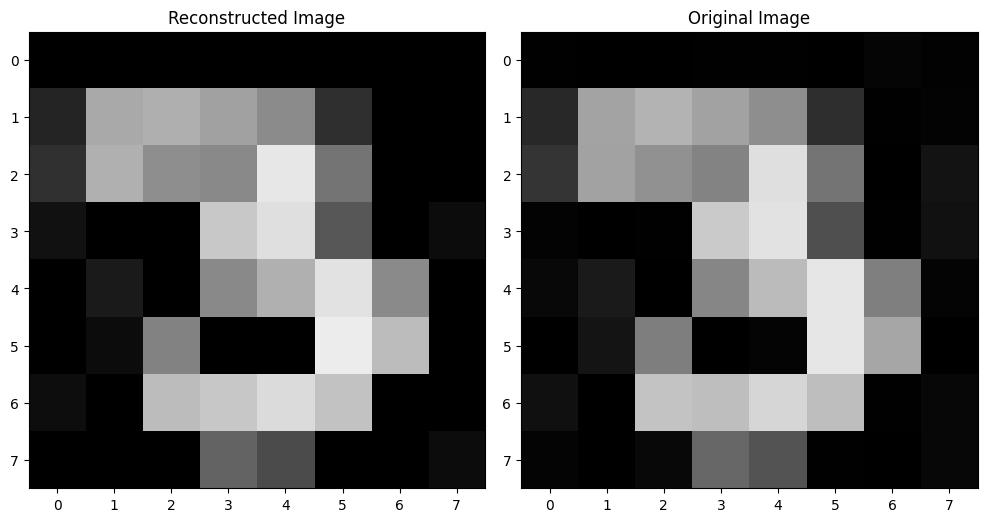

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(output_im, cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Reconstructed Image')
axs[1].imshow(image, cmap='gray', vmin=0, vmax=255)
axs[1].set_title('Original Image')

plt.tight_layout()